In [1]:
LAUNCH_VARIANT,ENSEMBLE_SOLUTIONS = 'option 89',['SOLUTION_11','SOLUTION_9']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import itertools
from scipy.optimize import minimize
from functools import partial
import random, os
from astropy.stats import sigma_clip

In [3]:
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [4]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

def clean_dark(signal, dark, dt):
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal

def preproc(dataset, adc_info, sensor, binning = 15):
    cut_inf, cut_sup = 39, 321
    sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
    binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
    linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
    planet_ids = adc_info.index
    
    feats = []
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
        dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
        dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
        flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
        linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

        signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
        gain = adc_info[f'{sensor}_adc_gain'].values[i]
        offset = adc_info[f'{sensor}_adc_offset'].values[i]
        signal = signal / gain + offset
        
        hot = sigma_clip(
            dark_frame, sigma=5, maxiters=5
        ).mask
        
        if sensor != "FGS1":
            signal = signal[:, :, cut_inf:cut_sup] #11250 * 32 * 282
            #dt = axis_info['AIRS-CH0-integration_time'].dropna().values
            dt = np.ones(len(signal))*0.1 
            dt[1::2] += 4.5 #@bilzard idea
            linear_corr = linear_corr[:, :, cut_inf:cut_sup]
            dark_frame = dark_frame[:, cut_inf:cut_sup]
            dead_frame = dead_frame[:, cut_inf:cut_sup]
            flat_frame = flat_frame[:, cut_inf:cut_sup]
            hot = hot[:, cut_inf:cut_sup]
        else:
            dt = np.ones(len(signal))*0.1
            dt[1::2] += 0.1
            
        signal = signal.clip(0) #@graySnow idea
        linear_corr_signal = apply_linear_corr(linear_corr, signal)
        signal = clean_dark(linear_corr_signal, dark_frame, dt)
        
        flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
        flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
        signal = signal / flat
        
        if sensor == "FGS1":
            signal = signal.reshape((sensor_sizes_dict[sensor][0][0], sensor_sizes_dict[sensor][0][1]*sensor_sizes_dict[sensor][0][2]))
        
        mean_signal = np.nanmean(signal, axis=1) # mean over the 32*32(FGS1) or 32(CH0) pixels
        cds_signal = (mean_signal[1::2] - mean_signal[0::2])
        
        binned = np.zeros((binned_dict[sensor]))
        for j in range(cds_signal.shape[0] // binning):
            binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0)
                   
        if sensor == "FGS1":
            binned = binned.reshape((binned.shape[0],1))
            
        feats.append(binned)
        
    return np.stack(feats)
    
pre_train = np.concatenate([preproc('test', test_adc_info, "FGS1", 30*12), preproc('test', test_adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


In [5]:
def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50//2,150//2):        
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase1 = i+(20+5)//2
            best_drop = t1
    
    best_drop = 0
    for i in range(200//2,250//2):
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase2 = i-5//2
            best_drop = t1
    
    return phase1, phase2

def try_s(signal, p1, p2, deg, s):
    out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
    x, y = out, signal[out].tolist()
    x = x + list(range(p1,p2))

    y = y + (signal[p1:p2] * (1 + s[0])).tolist()
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q
    
def calibrate_signal(signal):
    p1,p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
        
        print(deg, q)
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)

    return s, x, y, p(x)

def calibrate_train(signal):
    p1,p2 = phase_detector(signal)
    
    best_deg, best_score = 1, 1e12
    for deg in range(1, 6):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)
    
    return s, p(np.arange(signal.shape[0])), p1, p2


train = pre_train.copy()
all_s = []
for i in range(len(test_adc_info)):
    signal = train[i,:,1:].mean(axis=1)
    s, p, p1, p2 = calibrate_train(pre_train[i,:,1:].mean(axis=1))
    all_s.append(s)
        
#copy answer 283 times because we predict mean value
train_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        
train_sigma = np.ones_like(train_s) * 0.000176

1 0.07244656257090913
2 0.06997614558677229
3 0.06340499597848703
4 0.06369586726506939
5 0.06329606118528834


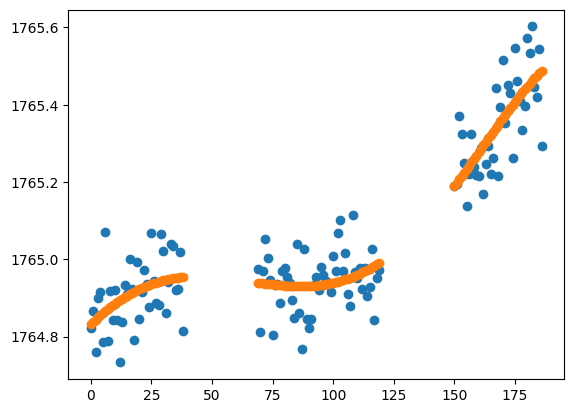

In [6]:
n = 0
s, x, y, y_new = calibrate_signal(pre_train[n,:,1:].mean(axis=1))
plt.scatter(x,y)
plt.scatter(x,y_new)

In [7]:
ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

preds = train_s.clip(0)
sigmas = train_sigma
submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
submission.index = test_adc_info.index
submission.to_csv('submission_2.csv')

In [8]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import scipy.stats
    from tqdm import tqdm

    from sklearn.model_selection import cross_val_predict
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools
    from scipy.optimize import minimize
    from functools import partial
    import random, os
    from astropy.stats import sigma_clip

In [9]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                               index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [10]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=8, maxiters=5
            ).mask

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] #11250 * 32 * 282
                #dt = axis_info['AIRS-CH0-integration_time'].dropna().values
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += 4.5 #@bilzard idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat

            if sensor == "FGS1":
                signal = signal.reshape((sensor_sizes_dict[sensor][0][0], sensor_sizes_dict[sensor][0][1]*sensor_sizes_dict[sensor][0][2]))

            mean_signal = np.nanmean(signal, axis=1) # mean over the 32*32(FGS1) or 32(CH0) pixels
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0)

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc('test', test_adc_info, "FGS1", 30*12), preproc('test', test_adc_info, "AIRS-CH0", 30)], axis=2)

In [11]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):
        phase1, phase2 = None, None
        best_drop = 0
        for i in range(50//2,150//2):        
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase1 = i+(20+5)//2
                best_drop = t1

        best_drop = 0
        for i in range(200//2,250//2):
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase2 = i-5//2
                best_drop = t1

        return phase1, phase2

    def try_s(signal, p1, p2, deg, s):
        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))

        y = y + (signal[p1:p2] * (1 + s[0])).tolist()
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()

        if s < 1e-4:
            return q + 1e3

        return q

    def calibrate_signal(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 6):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

            print(deg, q)

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, x, y, p(x)

    def calibrate_train(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 6):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.0001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, p(np.arange(signal.shape[0])), p1, p2


    train = pre_train.copy()
    all_s = []
    for i in range(len(test_adc_info)):
        signal = train[i,:,1:].mean(axis=1)
        s, p, p1, p2 = calibrate_train(pre_train[i,:,1:].mean(axis=1))
        all_s.append(s)

    #copy answer 283 times because we predict mean value
    train_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        
    train_sigma = np.ones_like(train_s) * 0.000176

In [12]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    n = 0
    s, x, y, y_new = calibrate_signal(pre_train[n,:,1:].mean(axis=1))
    plt.scatter(x,y)
    plt.scatter(x,y_new)

In [13]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:    
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    preds = train_s.clip(0)
    sigmas = train_sigma
    submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
    submission.index = test_adc_info.index
    submission.to_csv('submission_7.csv')

In [14]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm import tqdm
    import joblib

    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools

    from scipy.optimize import minimize
    from scipy import optimize

    from astropy.stats import sigma_clip

In [15]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    dataset = 'test'
    adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/'+f'{dataset}_adc_info.csv',index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [16]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=5, maxiters=5
            ).mask

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] 
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += 4.5 #@bilzard idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat


            if sensor == "FGS1":
                signal = signal[:,10:22,10:22] # **** updates ****
                signal = signal.reshape(sensor_sizes_dict[sensor][0][0],144) # # **** updates ****

            if sensor != "FGS1":
                signal = signal[:,10:22,:] # **** updates ****

            mean_signal = np.nanmean(signal, axis=1) 
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0) 

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc(f'{dataset}', adc_info, "FGS1", 30*12), preproc(f'{dataset}', adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


In [17]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):

        MIN = np.argmin(signal[30:140])+30
        signal1 = signal[:MIN ]
        signal2 = signal[MIN :]

        first_derivative1 = np.gradient(signal1)
        first_derivative1 /= first_derivative1.max()
        first_derivative2 = np.gradient(signal2)
        first_derivative2 /= first_derivative2.max()

        phase1 = np.argmin(first_derivative1)
        phase2 = np.argmax(first_derivative2) + MIN

        return phase1, phase2

    def objective(s):

        best_q = 1e10
        for i in range(4) :
            delta = 2
            x = list(range(signal.shape[0]-delta*4))
            y = signal[:p1-delta].tolist() + (signal[p1+delta:p2 - delta] * (1 + s)).tolist() + signal[p2+delta:].tolist()

            z = np.polyfit(x, y, deg=i)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

        if q < best_q :
            best_q = q

        return q


    all_s = []
    for i in tqdm(range(len(adc_info))):

        signal = pre_train[i,:,1:].mean(axis=1)
        p1,p2 = phase_detector(signal)

        r = minimize(
                    objective,
                    [0.0001],
                    method= 'Nelder-Mead'
                      )
        s = r.x[0]
        all_s.append(s)

    all_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        

100%|██████████| 1/1 [00:00<00:00, 31.85it/s]


In [18]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    __k = 0.000140985 # 0.0001422

    sigma = np.ones_like(all_s) * __k
    pred = all_s.clip(0) 
    submission = pd.DataFrame(np.concatenate([pred,sigma], axis=1), columns=ss.columns[1:])
    submission.index = adc_info.index
    submission.to_csv('submission_9.csv')
    submission

In [19]:
if 'SOLUTION_10' in ENSEMBLE_SOLUTIONS:

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm import tqdm
    import joblib
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools
    from scipy.optimize import minimize
    from scipy import optimize
    from astropy.stats import sigma_clip

    dataset = 'test'
    adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/'+f'{dataset}_adc_info.csv',index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [20]:
if 'SOLUTION_10' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=5, maxiters=5
            ).mask
            
            bilzard_idea = 4.5
            
            if LAUNCH_VARIANT == 'option 70': bilzard_idea = 4.15
            if LAUNCH_VARIANT == 'option 71': bilzard_idea = 4.85
            if LAUNCH_VARIANT == 'option 72': bilzard_idea = 5.15

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] 
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += bilzard_idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat


            if sensor == "FGS1":
                signal = signal[:,10:22,10:22] # **** updates ****
                signal = signal.reshape(sensor_sizes_dict[sensor][0][0],144) # # **** updates ****

            if sensor != "FGS1":
                signal = signal[:,10:22,:] # **** updates ****

            mean_signal = np.nanmean(signal, axis=1) 
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0) 

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc(f'{dataset}', adc_info, "FGS1", 30*12), preproc(f'{dataset}', adc_info, "AIRS-CH0", 30)], axis=2)

In [21]:
if 'SOLUTION_10' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):

        MIN = np.argmin(signal[30:140])+30
        signal1 = signal[:MIN ]
        signal2 = signal[MIN :]

        first_derivative1 = np.gradient(signal1)
        first_derivative1 /= first_derivative1.max()
        first_derivative2 = np.gradient(signal2)
        first_derivative2 /= first_derivative2.max()

        phase1 = np.argmin(first_derivative1)
        phase2 = np.argmax(first_derivative2) + MIN

        return phase1, phase2

    def objective(s):

        best_q = 1e10
        for i in range(4) :
            delta = 2
            x = list(range(signal.shape[0]-delta*4))
            y = signal[:p1-delta].tolist() + (signal[p1+delta:p2 - delta] * (1 + s)).tolist() + signal[p2+delta:].tolist()

            z = np.polyfit(x, y, deg=i)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

        if q < best_q :
            best_q = q

        return q
    
    
    _k_min = 0.0001
    
    if LAUNCH_VARIANT == 'option 70': _k_min = 0.00015
    if LAUNCH_VARIANT == 'option 71': _k_min = 0.000085
    if LAUNCH_VARIANT == 'option 72': _k_min = 0.00021


    all_s = []
    for i in tqdm(range(len(adc_info))):

        signal = pre_train[i,:,1:].mean(axis=1)
        p1,p2 = phase_detector(signal)

        r = minimize(
                    objective,
                    [0.00015],
                    method= 'Nelder-Mead'
                      )
        s = r.x[0]
        all_s.append(s)

    all_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        

In [22]:
if 'SOLUTION_10' in ENSEMBLE_SOLUTIONS:
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    __k = 0.0001422

    sigma = np.ones_like(all_s) * __k
    pred = all_s.clip(0) 
    submission = pd.DataFrame(np.concatenate([pred,sigma], axis=1), columns=ss.columns[1:])
    submission.index = adc_info.index
    submission.to_csv('submission_10.csv')
    submission

In [23]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import scipy.stats
    from tqdm import tqdm

    from sklearn.model_selection import cross_val_predict
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools
    from scipy.optimize import minimize
    from functools import partial
    import random, os
    from astropy.stats import sigma_clip

In [24]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                               index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [25]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=8, maxiters=5
            ).mask

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] #11250 * 32 * 282
                #dt = axis_info['AIRS-CH0-integration_time'].dropna().values
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += 4.5 #@bilzard idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat

            if sensor == "FGS1":
                signal = signal.reshape((sensor_sizes_dict[sensor][0][0], sensor_sizes_dict[sensor][0][1]*sensor_sizes_dict[sensor][0][2]))

            mean_signal = np.nanmean(signal, axis=1) # mean over the 32*32(FGS1) or 32(CH0) pixels
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0)

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc('test', test_adc_info, "FGS1", 30*12), preproc('test', test_adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


In [26]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):
        phase1, phase2 = None, None
        best_drop = 0
        for i in range(50//2,150//2):        
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase1 = i+(20+5)//2
                best_drop = t1

        best_drop = 0
        for i in range(200//2,250//2):
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase2 = i-5//2
                best_drop = t1

        return phase1, phase2

    def try_s(signal, p1, p2, deg, s):
        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))

        y = y + (signal[p1:p2] * (1 + s[0])).tolist()
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()

        if s < 1e-4:
            return q + 1e3

        return q

    def calibrate_signal(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 4):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

            print(deg, q)

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, x, y, p(x)

    def calibrate_train(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 4):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.0001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, p(np.arange(signal.shape[0])), p1, p2


    train = pre_train.copy()
    all_s = []
    for i in range(len(test_adc_info)):
        signal = train[i,:,1:].mean(axis=1)
        s, p, p1, p2 = calibrate_train(pre_train[i,:,1:].mean(axis=1))
        all_s.append(s)

    #copy answer 283 times because we predict mean value
    train_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283)) 
    
    _k_sigma = 0.000176
    
    if LAUNCH_VARIANT == 'option 87': _k_sigma = 0.000177
    if LAUNCH_VARIANT == 'option 88': _k_sigma = 0.000178
    if LAUNCH_VARIANT == 'option 89': _k_sigma = 0.000179
    
    train_sigma = np.ones_like(train_s) * _k_sigma

1 0.07244680006452496
2 0.07002299921950764
3 0.06342300208129605


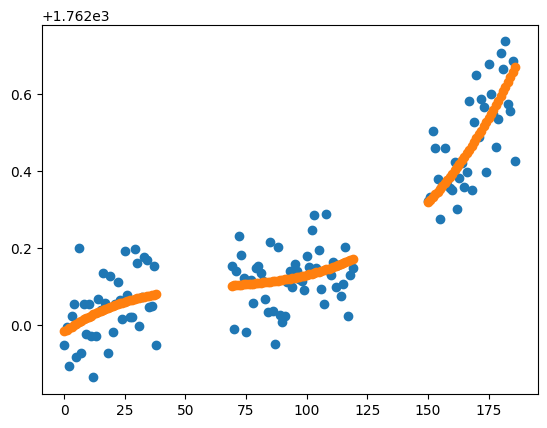

In [27]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    n = 0
    s, x, y, y_new = calibrate_signal(pre_train[n,:,1:].mean(axis=1))
    plt.scatter(x,y)
    plt.scatter(x,y_new)

In [28]:
if 'SOLUTION_11' in ENSEMBLE_SOLUTIONS:
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    preds = train_s.clip(0)
    sigmas = train_sigma
    submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
    submission.index = test_adc_info.index
    submission.to_csv('submission_11.csv')

## Ensemble of solutions

In [29]:
if LAUNCH_VARIANT == 'option 87' or LAUNCH_VARIANT == 'option 88' or LAUNCH_VARIANT == 'option 89':
    df_solution_x  = pd.read_csv('submission_11.csv')
    df_solution_11 = pd.read_csv('submission_11.csv')
    df_solution_9  = pd.read_csv('submission_9.csv')
    df_solution_11 = df_solution_11.map(lambda x:x*0.0303215)
    df_solution_9  = df_solution_9 .map(lambda x:x*0.9696785)
    df_temp = df_solution_11.add(df_solution_9)
    display(df_temp)
    df_submission = df_temp.map(lambda x:x)
    display(df_submission)
    df_submission['planet_id'] = df_solution_x['planet_id']


if LAUNCH_VARIANT == 'option 63':
    df_solution_x = pd.read_csv('submission_7.csv')
    df_solution_7 = pd.read_csv('submission_7.csv')
    df_solution_9 = pd.read_csv('submission_9.csv')
    df_solution_7 = df_solution_7.map(lambda x:x*0.0303215)
    df_solution_9 = df_solution_9.map(lambda x:x*0.9696785)
    df_temp = df_solution_7.add(df_solution_9)
    display(df_temp)
    df_submission = df_temp.map(lambda x:x)
    display(df_submission)
    df_submission['planet_id'] = df_solution_x['planet_id']

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466.0,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466.0,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142


In [30]:
df_submission.to_csv('submission.csv', index=False, float_format='%.8f')
df_submission

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,0.002724,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142
